# Introduction

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2021-08-04 08:37:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data’

drug_consumption.da 100%[===================>] 338.57K  1.28MB/s    in 0.3s    

2021-08-04 08:37:24 (1.28 MB/s) - ‘drug_consumption.data’ saved [346695/346695]



We will solve 3 problems:

1.   Multi-label classification for each drug separately
2.   Binary classification for each drug separately
3.   Binary classification for ecstasy users only (with detailed analysis and cross-validation)

A detailed description of the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
sns.set_style('darkgrid')

In [4]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [5]:
data.columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
                'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
                'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis',
                'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
                'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']

In [6]:
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 1 to 1888
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1885 non-null   float64
 1   Gender     1885 non-null   float64
 2   Education  1885 non-null   float64
 3   Country    1885 non-null   float64
 4   Ethnicity  1885 non-null   float64
 5   Nscore     1885 non-null   float64
 6   Escore     1885 non-null   float64
 7   Oscore     1885 non-null   float64
 8   Ascore     1885 non-null   float64
 9   Cscore     1885 non-null   float64
 10  Impulsive  1885 non-null   float64
 11  SS         1885 non-null   float64
 12  Alcohol    1885 non-null   object 
 13  Amphet     1885 non-null   object 
 14  Amyl       1885 non-null   object 
 15  Benzos     1885 non-null   object 
 16  Caff       1885 non-null   object 
 17  Cannabis   1885 non-null   object 
 18  Choc       1885 non-null   object 
 19  Coke       1885 non-null   object 
 20  Crack   

In [8]:
data.isnull().sum()

Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
Ascore       0
Cscore       0
Impulsive    0
SS           0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caff         0
Cannabis     0
Choc         0
Coke         0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semer        0
VSA          0
dtype: int64

# Data preprocessing

Replace the numeric data as specified in the description of the dataset.

In [9]:
data['Age'].replace(np.sort(data['Age'].unique()), 
                    ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
                    inplace=True)

data['Gender'] = np.round(data['Gender'], 5)
data['Gender'].replace([0.48246, -0.48246], ['Female', 'Male'], inplace=True)

education_val = ['Left school <16', 'Left school 16', 'Left school 17',
                 'Left school 18', 'University/college', 'Certificate/diploma',
                 'University degree', 'Master degree', 'Doctorate degree']
data['Education'].replace(np.sort(data['Education'].unique()), education_val, inplace=True)

data['Country'] = np.round(data['Country'], 5)
data['Country'].replace([-0.09765, 0.24923, -0.46841, -0.28519, 0.21128, 0.96082, -0.57009], 
                        ['Australia', 'Canada', 'New Zealand', 'Other', 'Ireland', 'UK', 'USA'],
                        inplace=True)

data['Ethnicity'] = np.round(data['Ethnicity'], 5)
data['Ethnicity'].replace([-0.50212, -1.10702, 1.90725, 0.12600, -0.22166, 0.11440, -0.31685],
                          ['Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian', 'Mixed-White/Black', 'Other', 'White'],
                          inplace=True)


data['Nscore'].replace(np.sort(data['Nscore'].unique()), list(range(12, 61)), inplace=True)

escore_val = list(range(16, 60))
escore_val.remove(17)
escore_val.remove(57)
data['Escore'].replace(np.sort(data['Escore'].unique()), escore_val, inplace=True)

oscore_val = list(range(24, 61))
oscore_val.remove(25)
oscore_val.remove(27)
data['Oscore'].replace(np.sort(data['Oscore'].unique()), oscore_val, inplace=True)

ascore_val = list(range(12, 61))
for x in [13, 14, 15, 17, 19, 20, 21, 22]:
  ascore_val.remove(x)
data['Ascore'].replace(np.sort(data['Ascore'].unique()), ascore_val, inplace=True)

cscore_val = list(range(17, 60))
cscore_val.remove(18)
cscore_val.remove(58)
data['Cscore'].replace(np.sort(data['Cscore'].unique()), cscore_val, inplace=True)

data['Impulsive'].replace(np.sort(data['Impulsive'].unique()),
                          [20, 276, 307, 355, 257, 216, 195, 148, 104, 7],
                          inplace=True)
data['SS'].replace(np.sort(data['SS'].unique()),
                   [71, 87, 132, 169, 211, 223, 219, 249, 211, 210, 103],
                   inplace=True)

for col in ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']:
  data[col] = data[col].astype(int)

We will replace the categorical data with numbers.

In [10]:
cat_features = ['Alcohol','Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 
                'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']

map_dict = {'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6}

# replacing with numeric labels
for feature in cat_features:
  data[feature] = data[feature].map(map_dict)

In [11]:
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,35-44,Female,Certificate/diploma,UK,Mixed-White/Asian,39,36,42,37,42,355,132,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,307,223,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
3,35-44,Male,Certificate/diploma,UK,White,31,45,40,32,34,276,249,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
4,18-24,Female,Master degree,UK,White,34,34,46,47,46,276,132,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,355,223,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0


# Visualization

Let's look at the distribution of drug users.

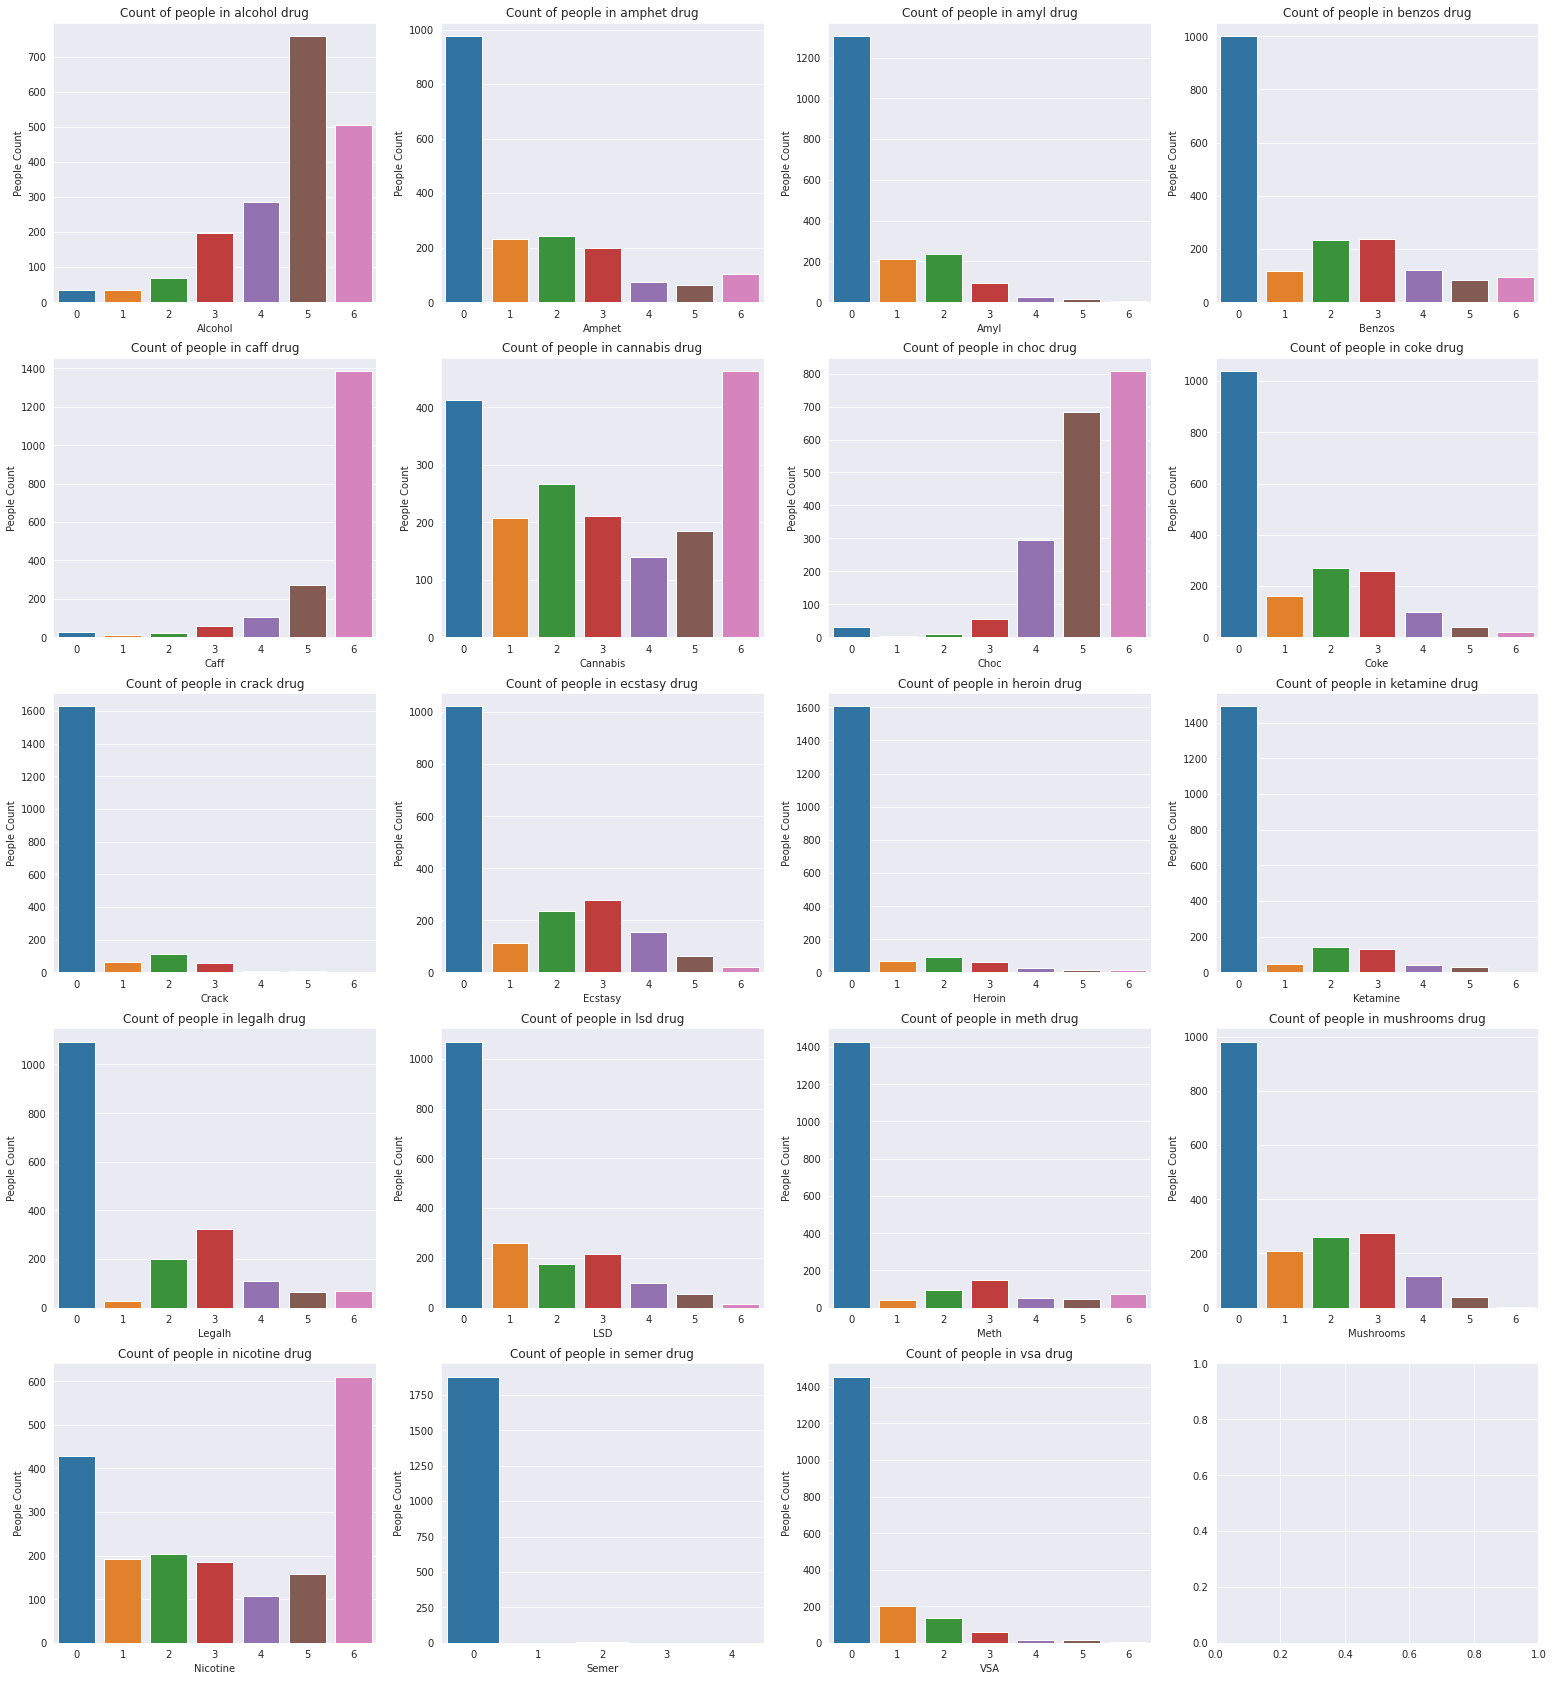

In [12]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
  plt.subplot(5, 4, i)
  sns.countplot(x=feature, data=data)
  plt.title('Count of people in {} drug'.format(feature.lower()))
  plt.ylabel('People Count')

There are legal drugs in the dataset - these are nicotine and alcohol. There are also harmless preparations here - caffeine and chocolate. We will not predict them, so we will remove them from the dataset. There is also a fictional drug for checking for honesty - semer. We will also remove it from the dataset.

In [13]:
for_removing = ['Alcohol', 'Nicotine', 'Caff', 'Choc', 'Semer']
data.drop(for_removing, axis=1, inplace=True)

Let's also look at the distribution of demographic data.

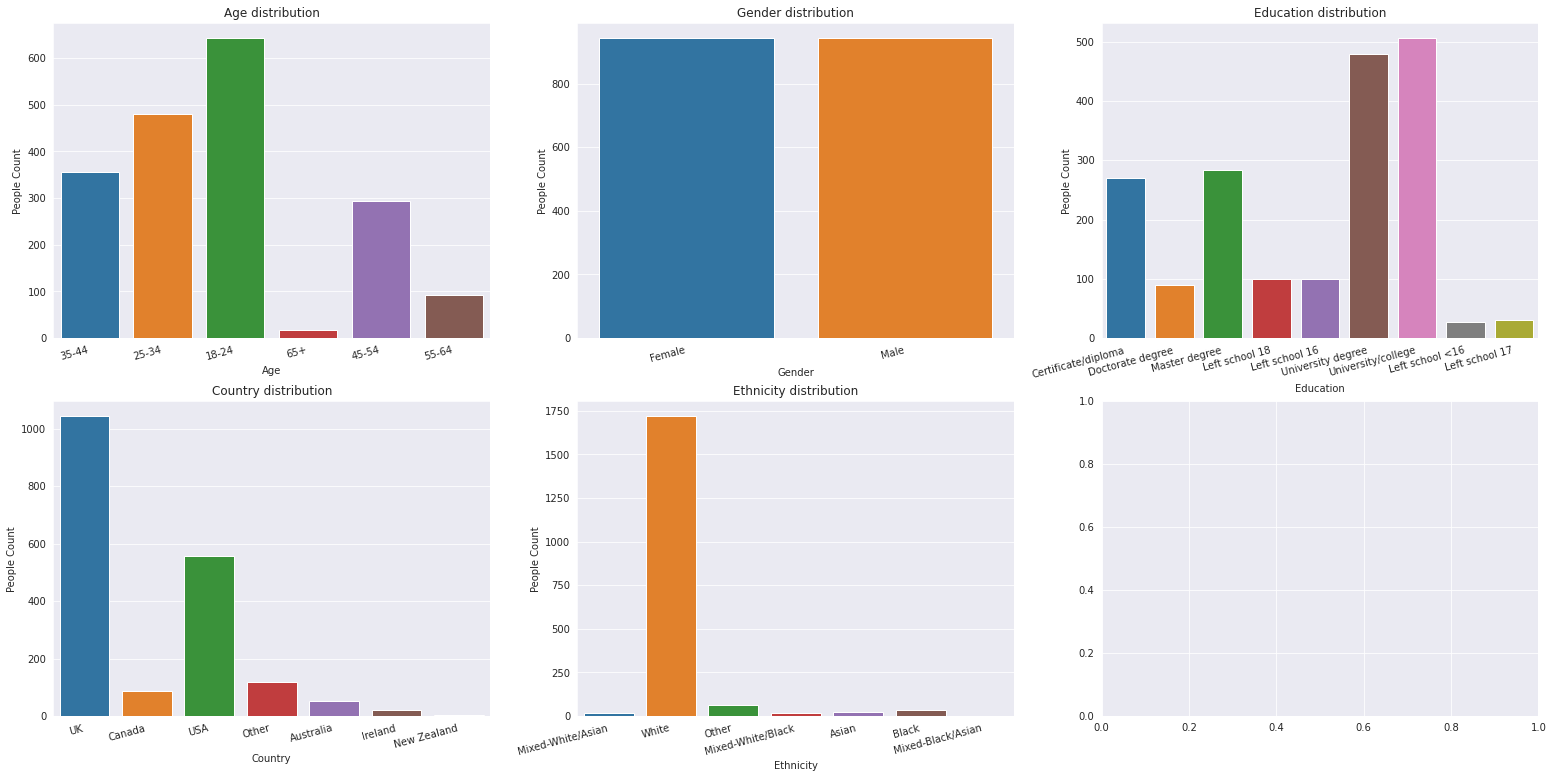

In [14]:
demografic_features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(demografic_features, 1):
  plt.subplot(2, 3, i)
  chart = sns.countplot(x=feature, data=data)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=15, horizontalalignment='right')
  plt.title('{} distribution'.format(feature))
  plt.ylabel('People Count')

As we can see, white people predominate in the sample, and there are very few others compared to them. Therefore, we will combine the remaining ethnic groups into the category "Others".

In [15]:
data['Ethnicity'].replace(['Asian', 'Black', 'Mixed-Black/Asian', 
                            'Mixed-White/Asian', 'Mixed-White/Black', 'Other'],
                           'Other',
                           inplace=True)

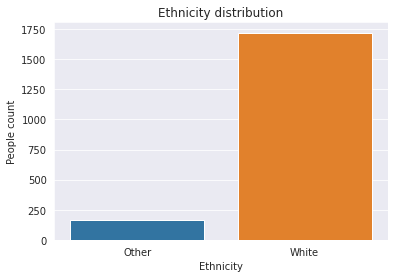

In [16]:
plt.figure()
sns.countplot(data=data, x='Ethnicity')
plt.title('Ethnicity distribution')
plt.xlabel('Ethnicity')
plt.ylabel('People count')
plt.show()

We will also combine Canada, Australia, Ireland, New Zealand and other countries in the "Other" category.

In [17]:
data['Country'].replace(['Canada', 'Australia', 'Ireland', 'New Zealand', 'Other'],
                        'Other',
                        inplace=True)

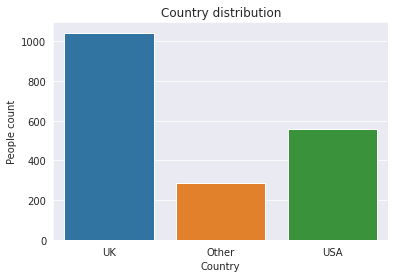

In [18]:
plt.figure()
sns.countplot(data=data, x='Country')
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('People count')
plt.show()

# Multilabel classification

In [19]:
def make_multilabel(data, feature_name):
  """
  Make multilabel target for feature in dataset

  Arguments:
    data, pandas.DataFrame: dataset with needed feature
    feature_name, str: feature to make multilabel

  Return:
    y, numpy.array: multilabel targets for each value in dataset
  """
  y = np.zeros((data.shape[0], 7))

  for i in range(data.shape[0]):
    value = data[feature_name].iloc[i]
    y[i, value] = 1

  return y

In [20]:
def one_hot_encoding(data, columns):
  """
  Applies one-hot encoding technique to data

  Arguments:
    data, pd.DataFrame: original data
    columns, list: columns to encoding

  Return:
    data, pd.DataFrame: data with encoded columns
  """
  for col in columns:
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
  
  data.drop(columns, axis=1, inplace=True)

  return data

In [21]:
illegal_drugs = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 
                 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'VSA']

In [22]:
X = data.drop(illegal_drugs, axis=1)
X = one_hot_encoding(X, demografic_features)

numeric_features = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])

In [23]:
X.head()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Gender_Female,Gender_Male,Education_Certificate/diploma,Education_Doctorate degree,Education_Left school 16,Education_Left school 17,Education_Left school 18,Education_Left school <16,Education_Master degree,Education_University degree,Education_University/college,Country_Other,Country_UK,Country_USA,Ethnicity_Other,Ethnicity_White
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.337059,-0.528234,-0.571966,-0.911428,0.080816,1.303400,-1.192420,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,-0.757818,1.835144,1.404350,0.797602,-0.062764,0.678848,0.614215,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,-0.538842,0.801166,-0.876015,-1.688260,-1.067821,0.275492,1.130396,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,-0.210379,-0.823656,0.036131,0.642236,0.655134,0.275492,-1.192420,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
5,0.775010,-1.709922,-0.419942,-0.289962,1.229453,1.303400,0.614215,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [24]:
arr = np.array([[0, 0, 0, 1], 
                [1, 0, 0, 0]])
# zero_ind = np.argwhere(arr == 0)
# zero_ind = arr[arr == 0]
# one_ind = np.argwhere(arr == 1)
# zero_ind
# arr[zero_ind] = 1
# arr[one_ind] = 0
# arr
(arr == 0).astype(int)

array([[1, 1, 1, 0],
       [0, 1, 1, 1]])

In [25]:
sensitivity_per_drug = []
specificity_per_drug = []

for drug in illegal_drugs:
  y = make_multilabel(data, drug)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

  tree = DecisionTreeClassifier(random_state=17)
  rf = RandomForestClassifier(random_state=17)
  knn = KNeighborsClassifier()

  models = [tree, rf, knn]

  sens = []
  spec = []

  for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    sensitivity = recall_score(y_test, preds, average='micro')
    specificity = recall_score((y_test == 0).astype(int), (preds == 0).astype(int), average='micro')

    sens.append(sensitivity)
    spec.append(specificity)

  sensitivity_per_drug.append(sens)
  specificity_per_drug.append(spec)

sensitivity_per_drug = np.array(sensitivity_per_drug)
specificity_per_drug = np.array(specificity_per_drug)

In [26]:
res_sens = {
    'Decision Tree': sensitivity_per_drug[:, 0],
    'Random Forest': sensitivity_per_drug[:, 1],
    'kNN': sensitivity_per_drug[:, 2]
}

multilabel_clf_res_sens = pd.DataFrame(data=res_sens,
                                       index=illegal_drugs)

res_spec = {
    'Decision Tree': specificity_per_drug[:, 0],
    'Random Forest': specificity_per_drug[:, 1],
    'kNN': specificity_per_drug[:, 2]
}

multilabel_clf_res_spec = pd.DataFrame(data=res_spec,
                                       index=illegal_drugs)

In [27]:
multilabel_clf_res_sens

,Decision Tree,Random Forest,kNN
Amphet,0.381625,0.321555,0.378092
Amyl,0.545936,0.621908,0.584806
Benzos,0.385159,0.365724,0.406360
Cannabis,0.252650,0.127208,0.231449
Coke,0.397527,0.395760,0.402827
Crack,0.772085,0.855124,0.846290
Ecstasy,0.399293,0.381625,0.413428
Heroin,0.773852,0.833922,0.800353
Ketamine,0.636042,0.773852,0.727915
Legalh,0.507067,0.498233,0.528269


In [28]:
multilabel_clf_res_spec

,Decision Tree,Random Forest,kNN
Amphet,0.896938,0.972909,0.960836
Amyl,0.924323,0.967609,0.960247
Benzos,0.897527,0.974382,0.956714
Cannabis,0.875442,0.981154,0.955830
Coke,0.899588,0.969670,0.957597
Crack,0.962014,0.979388,0.978799
Ecstasy,0.899882,0.973498,0.954947
Heroin,0.962309,0.979976,0.980860
Ketamine,0.939340,0.967903,0.967903
Legalh,0.917845,0.980860,0.969081


# Binary classification

There are several ways to get to the binary classification problem:



1.   "Never used" and "Used over a decade ago" are placed into the class of non-users and all other answers into the class of users. This is "decade-based" separation.
2.   "Used in last decade", "Used over a decade ago" and "Never used" are placed into the class of non-users and all other answers into the class of users. This is "year-based" separation.
3.   "Used in last year", "Used in last decade", "Used over a decade ago" and "Never used" are placed into the class of non-users and all other answers into the class of users. This is "month-based" separation.
4.    "Used in last week" and "Used in last month" are placed into the class of users and all other answers into the class of non-users. This is "week-based" separation.

In [29]:
def plot_target_dist(data, features):
  """
  Plots target distribution by categorical features in dataset

  Arguments:
    data, pandas.DataFrame: dataset for plotting
    features, list: features required for plotting
  """
  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
  plt.subplots_adjust(right=1.5, top=1.25)

  for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.countplot(x=feature, data=data, hue=feature)
    plt.legend(['Non users of {}'.format(feature), 'Users of {}'.format(feature)])
    plt.xlabel('')
    plt.ylabel('People Count')

In [30]:
def train(data, targets):
  """
  Trains models and computes difference between
  for each model sensivity and specifity for each model

  Arguments:
    data, pandas.DataFrame: dataset for training
    targets, list: list of target features

  Return:
    results, list: lists of dataframes with results of training
  """
  demografic_features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']
  numeric_features = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
  X = data.drop(targets, axis=1)
  X = one_hot_encoding(X, demografic_features)
  X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])

  sensitivity_per_drug = []
  specificity_per_drug = []

  for target in targets:
    y = data_decade[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

    tree = DecisionTreeClassifier(random_state=17)
    rf = RandomForestClassifier(random_state=17)
    knn = KNeighborsClassifier()
    logreg = LogisticRegression(random_state=17)

    models = [tree, rf, knn, logreg]

    sens = []
    spec = []

    for model in models:
      model.fit(X_train, y_train)
      
      sensitivity = recall_score(y_test, model.predict(X_test))
      specificity = recall_score(y_test, model.predict(X_test), pos_label=0)
      
      sens.append(sensitivity)
      spec.append(specificity)

    sensitivity_per_drug.append(sens)
    specificity_per_drug.append(spec)

  sensitivity_per_drug = np.array(sensitivity_per_drug)
  specificity_per_drug = np.array(specificity_per_drug)
  
  res_sens = {
    'Decision Tree': sensitivity_per_drug[:, 0],
    'Random Forest': sensitivity_per_drug[:, 1],
    'kNN': sensitivity_per_drug[:, 2],
    'Logistic Regression': sensitivity_per_drug[:, 3]
  }

  multilabel_clf_res_sens = pd.DataFrame(data=res_sens,
                                         index=targets)

  res_spec = {
      'Decision Tree': specificity_per_drug[:, 0],
      'Random Forest': specificity_per_drug[:, 1],
      'kNN': specificity_per_drug[:, 2],
      'Logistic Regression': specificity_per_drug[:, 3]
  }

  multilabel_clf_res_spec = pd.DataFrame(data=res_spec,
                                         index=targets)

  results = [multilabel_clf_res_sens, multilabel_clf_res_spec]
  return results

## Decade-based separation

In [31]:
data_decade = data.copy()
data_decade.replace([0, 1], 0, inplace=True)
data_decade.replace([2, 3, 4, 5, 6], 1, inplace=True)

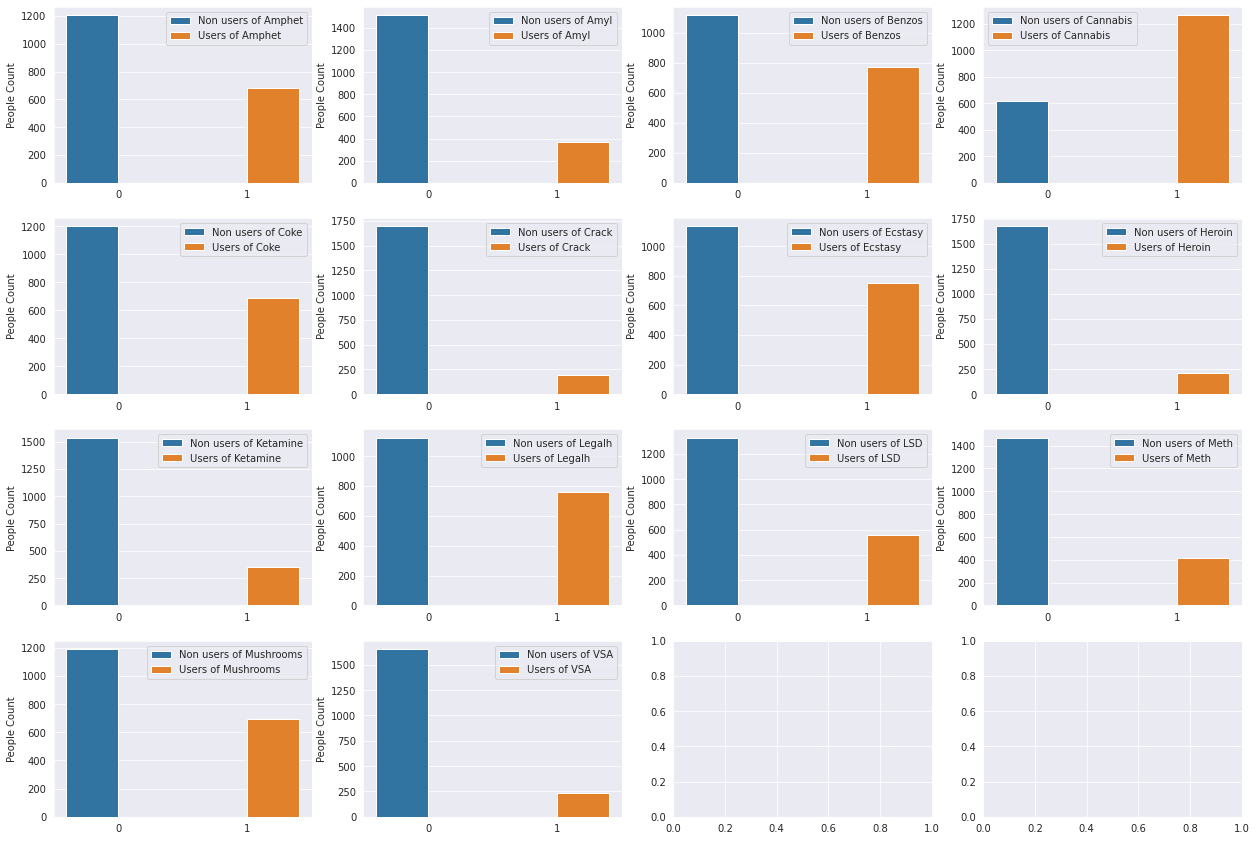

In [32]:
plot_target_dist(data_decade, illegal_drugs)

In [33]:
results = train(data_decade, illegal_drugs)

In [34]:
# results by sensitivity
results[0]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.569149,0.595745,0.563830,0.617021
Amyl,0.250000,0.134615,0.173077,0.115385
Benzos,0.560976,0.565854,0.526829,0.570732
Cannabis,0.798913,0.869565,0.823370,0.875000
Coke,0.482412,0.407035,0.477387,0.492462
Crack,0.254545,0.018182,0.072727,0.018182
Ecstasy,0.556054,0.618834,0.609865,0.627803
Heroin,0.320755,0.113208,0.245283,0.094340
Ketamine,0.283019,0.028302,0.141509,0.084906
Legalh,0.678899,0.711009,0.692661,0.724771


In [35]:
# results by specificity
results[1]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.719577,0.809524,0.788360,0.835979
Amyl,0.831169,0.984848,0.922078,0.980519
Benzos,0.614958,0.795014,0.767313,0.797784
Cannabis,0.575758,0.621212,0.616162,0.712121
Coke,0.667575,0.852861,0.762943,0.833787
Crack,0.888454,0.994129,0.982387,0.990215
Ecstasy,0.743440,0.819242,0.775510,0.825073
Heroin,0.906433,0.980507,0.941520,0.974659
Ketamine,0.806522,0.989130,0.936957,0.982609
Legalh,0.701149,0.844828,0.801724,0.839080


## Year-based separation

In [36]:
data_year = data.copy()
data_year.replace([0, 1, 2], 0, inplace=True)
data_year.replace([3, 4, 5, 6], 1, inplace=True)

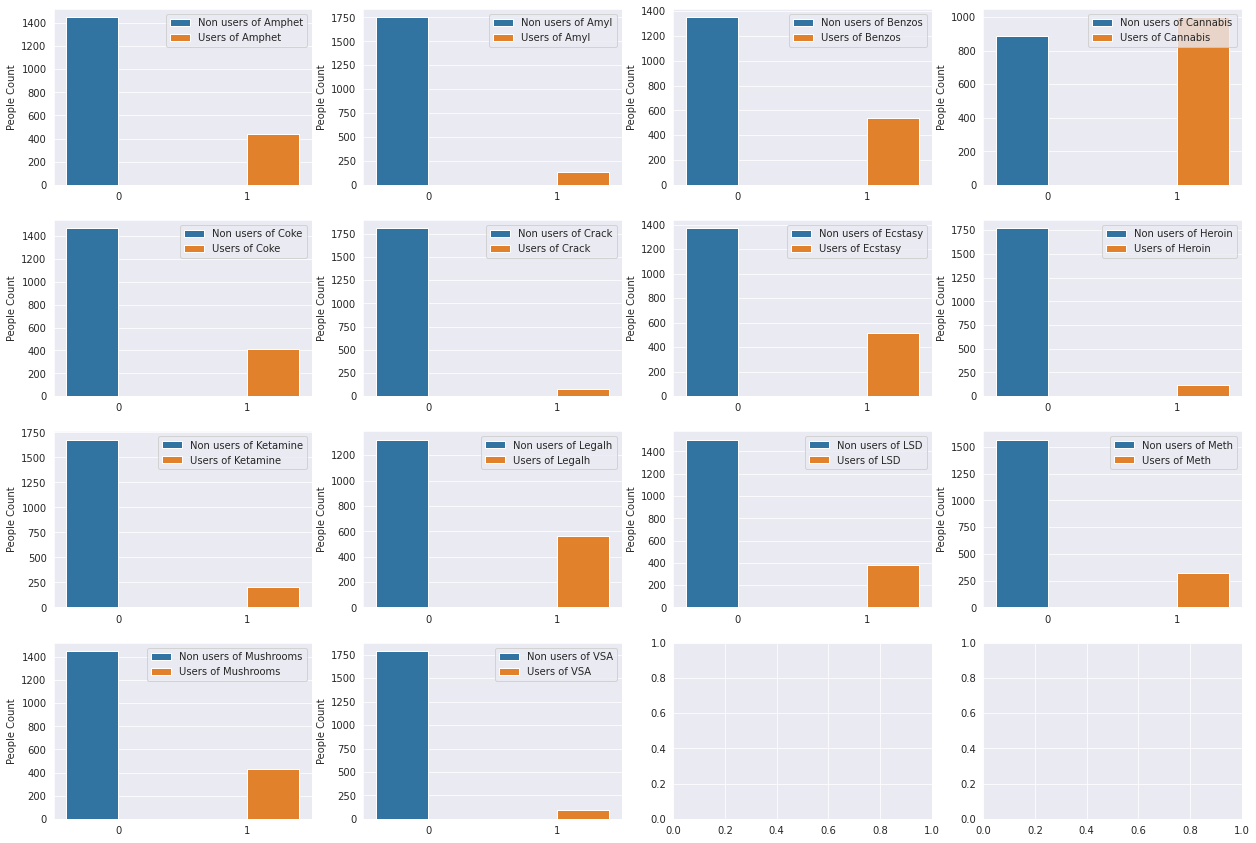

In [37]:
plot_target_dist(data_year, illegal_drugs)

In [38]:
results = train(data_year, illegal_drugs)

In [39]:
# results by sensitivity
results[0]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.569149,0.595745,0.563830,0.617021
Amyl,0.250000,0.134615,0.173077,0.115385
Benzos,0.560976,0.565854,0.526829,0.570732
Cannabis,0.798913,0.869565,0.823370,0.875000
Coke,0.482412,0.407035,0.477387,0.492462
Crack,0.254545,0.018182,0.072727,0.018182
Ecstasy,0.556054,0.618834,0.609865,0.627803
Heroin,0.320755,0.113208,0.245283,0.094340
Ketamine,0.283019,0.028302,0.141509,0.084906
Legalh,0.678899,0.711009,0.692661,0.724771


In [40]:
# results by specificity
results[1]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.719577,0.809524,0.788360,0.835979
Amyl,0.831169,0.984848,0.922078,0.980519
Benzos,0.614958,0.795014,0.767313,0.797784
Cannabis,0.575758,0.621212,0.616162,0.712121
Coke,0.667575,0.852861,0.762943,0.833787
Crack,0.888454,0.994129,0.982387,0.990215
Ecstasy,0.743440,0.819242,0.775510,0.825073
Heroin,0.906433,0.980507,0.941520,0.974659
Ketamine,0.806522,0.989130,0.936957,0.982609
Legalh,0.701149,0.844828,0.801724,0.839080


## Month-based separation

In [41]:
data_month = data.copy()
data_month.replace([0, 1, 2, 3], 0, inplace=True)
data_month.replace([4, 5, 6], 1, inplace=True)

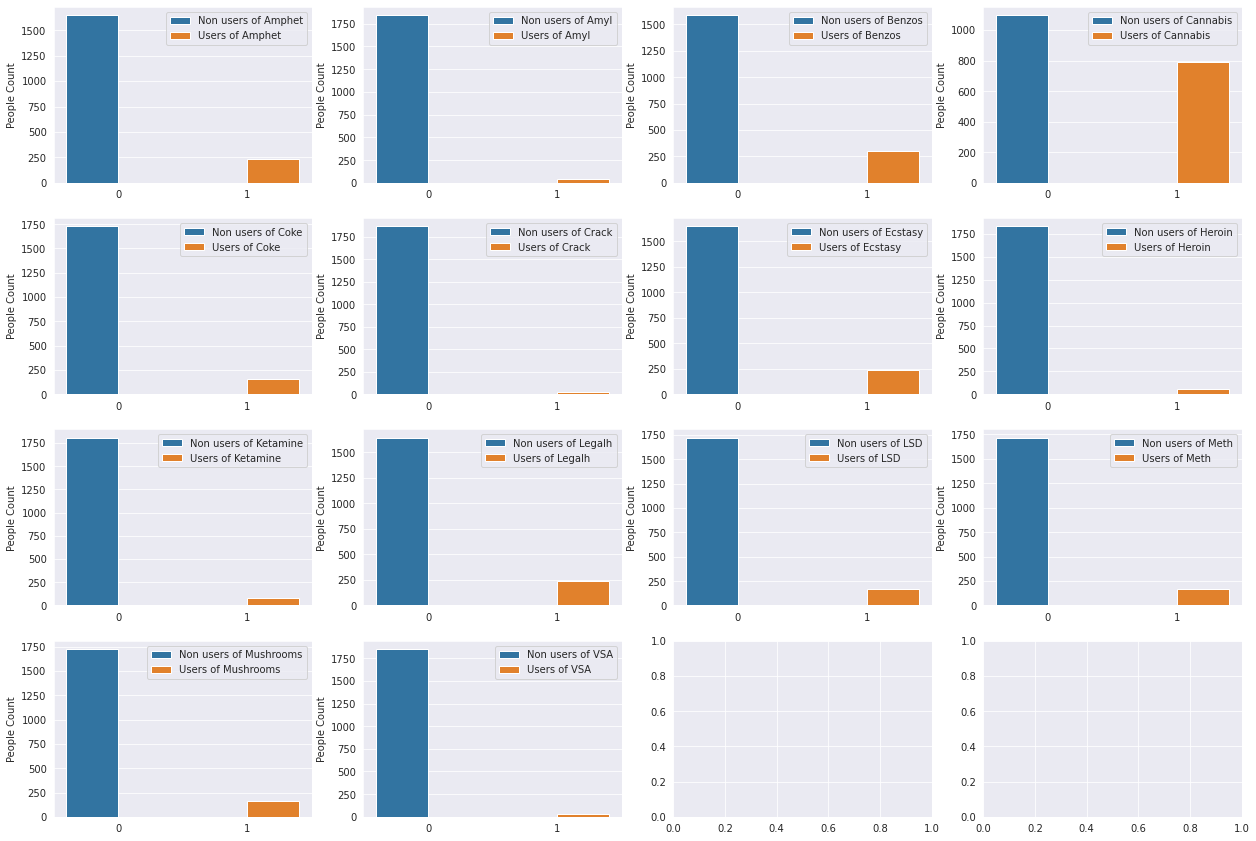

In [42]:
plot_target_dist(data_month, illegal_drugs)

In [43]:
results = train(data_month, illegal_drugs)

In [44]:
# results by sensitivity
results[0]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.569149,0.595745,0.563830,0.617021
Amyl,0.250000,0.134615,0.173077,0.115385
Benzos,0.560976,0.565854,0.526829,0.570732
Cannabis,0.798913,0.869565,0.823370,0.875000
Coke,0.482412,0.407035,0.477387,0.492462
Crack,0.254545,0.018182,0.072727,0.018182
Ecstasy,0.556054,0.618834,0.609865,0.627803
Heroin,0.320755,0.113208,0.245283,0.094340
Ketamine,0.283019,0.028302,0.141509,0.084906
Legalh,0.678899,0.711009,0.692661,0.724771


In [45]:
# results by specificity
results[1]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.719577,0.809524,0.788360,0.835979
Amyl,0.831169,0.984848,0.922078,0.980519
Benzos,0.614958,0.795014,0.767313,0.797784
Cannabis,0.575758,0.621212,0.616162,0.712121
Coke,0.667575,0.852861,0.762943,0.833787
Crack,0.888454,0.994129,0.982387,0.990215
Ecstasy,0.743440,0.819242,0.775510,0.825073
Heroin,0.906433,0.980507,0.941520,0.974659
Ketamine,0.806522,0.989130,0.936957,0.982609
Legalh,0.701149,0.844828,0.801724,0.839080


## Week-based separation

In [46]:
data_week = data.copy()
data_week.replace([0, 1, 2, 3, 6], 0, inplace=True)
data_week.replace([4, 5], 1, inplace=True)

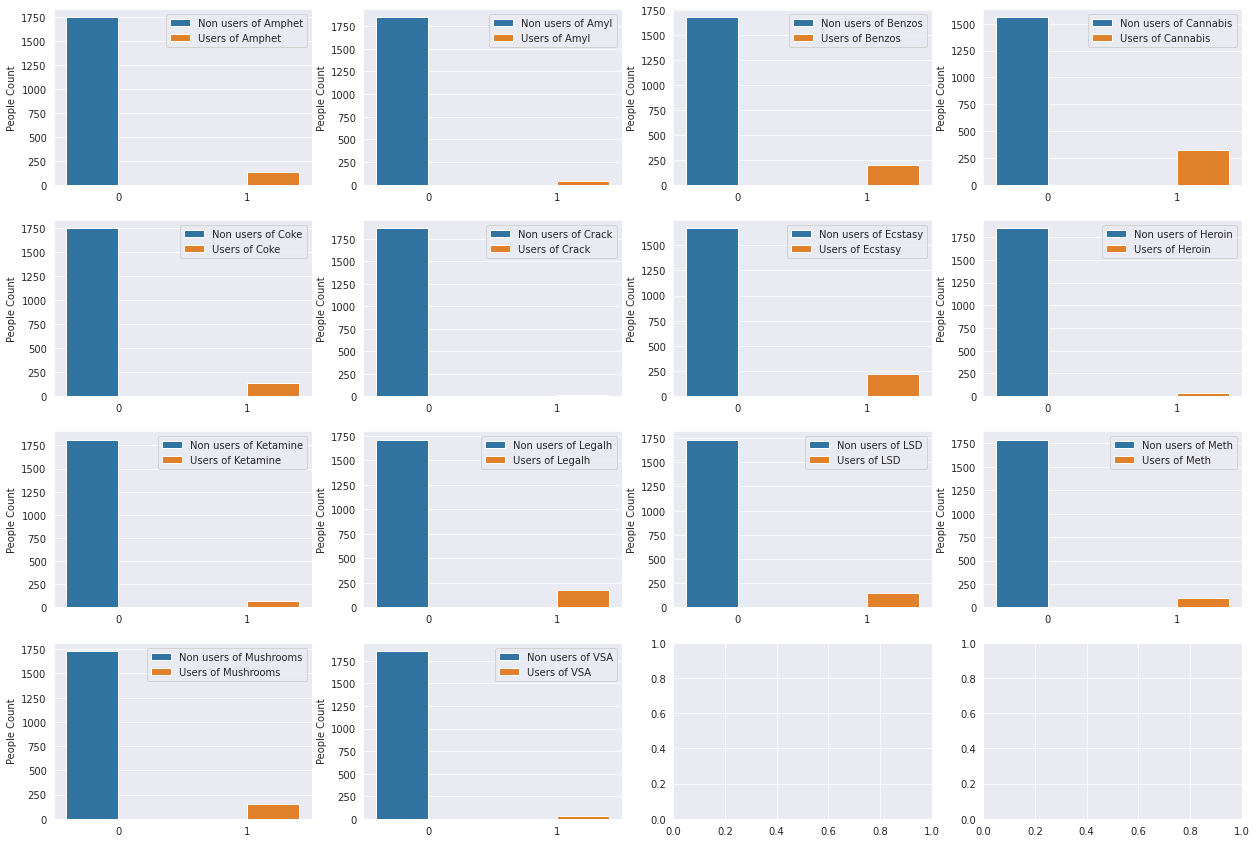

In [47]:
plot_target_dist(data_week, illegal_drugs)

In [48]:
results = train(data_month, illegal_drugs)

In [49]:
# results by sensitivity
results[0]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.569149,0.595745,0.563830,0.617021
Amyl,0.250000,0.134615,0.173077,0.115385
Benzos,0.560976,0.565854,0.526829,0.570732
Cannabis,0.798913,0.869565,0.823370,0.875000
Coke,0.482412,0.407035,0.477387,0.492462
Crack,0.254545,0.018182,0.072727,0.018182
Ecstasy,0.556054,0.618834,0.609865,0.627803
Heroin,0.320755,0.113208,0.245283,0.094340
Ketamine,0.283019,0.028302,0.141509,0.084906
Legalh,0.678899,0.711009,0.692661,0.724771


In [50]:
# results by specificity
results[1]

,Decision Tree,Random Forest,kNN,Logistic Regression
Amphet,0.719577,0.809524,0.788360,0.835979
Amyl,0.831169,0.984848,0.922078,0.980519
Benzos,0.614958,0.795014,0.767313,0.797784
Cannabis,0.575758,0.621212,0.616162,0.712121
Coke,0.667575,0.852861,0.762943,0.833787
Crack,0.888454,0.994129,0.982387,0.990215
Ecstasy,0.743440,0.819242,0.775510,0.825073
Heroin,0.906433,0.980507,0.941520,0.974659
Ketamine,0.806522,0.989130,0.936957,0.982609
Legalh,0.701149,0.844828,0.801724,0.839080


# Binary classification for ecstasy with decade-based separation

In [51]:
data_ecstasy = data.drop(illegal_drugs, axis=1)
data_ecstasy['Ecstasy'] = data['Ecstasy']

In [52]:
data_ecstasy.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Ecstasy
0,,,,,,,,,,,,,
1,35-44,Female,Certificate/diploma,UK,Other,39,36,42,37,42,355,132,0
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,307,223,4
3,35-44,Male,Certificate/diploma,UK,White,31,45,40,32,34,276,249,0
4,18-24,Female,Master degree,UK,White,34,34,46,47,46,276,132,0
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,355,223,1


In [53]:
data_ecstasy['Ecstasy'].replace([0, 1], 0, inplace=True)
data_ecstasy['Ecstasy'].replace([2, 3, 4, 5, 6], 1, inplace=True)

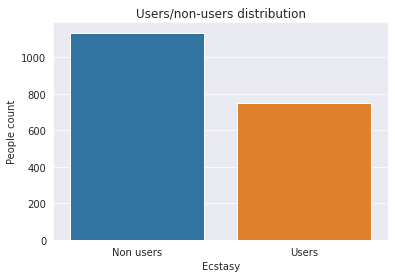

In [77]:
plt.figure()
sns.countplot(data=data_ecstasy, x='Ecstasy')
plt.title('Users/non-users distribution')
plt.ylabel('People count')
plt.xticks(ticks=[0, 1], labels=['Non users', 'Users'])
plt.show()

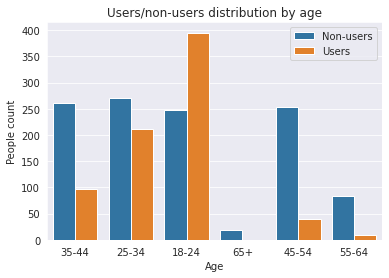

In [55]:
plt.figure()
sns.countplot(data=data_ecstasy, x='Age', hue='Ecstasy')
plt.title('Users/non-users distribution by age')
plt.ylabel('People count')
plt.legend(['Non-users', 'Users'])
plt.show()

In [56]:
print('Распределение users/non-users по возрасту в процентном соотношении в каждой группе.\n')
print('Age 18-24:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '18-24']['Ecstasy'].value_counts(normalize=True) * 100, 2))
print()
print('Age 25-34:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '25-34']['Ecstasy'].value_counts(normalize=True) * 100, 2))
print()
print('Age 35-44:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '35-44']['Ecstasy'].value_counts(normalize=True) * 100, 2))
print()
print('Age 45-54:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '45-54']['Ecstasy'].value_counts(normalize=True) * 100, 2))
print()
print('Age 55-64:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '55-64']['Ecstasy'].value_counts(normalize=True) * 100, 2))
print()
print('Age 65+:')
print(np.around(data_ecstasy[data_ecstasy['Age'] == '65+']['Ecstasy'].value_counts(normalize=True) * 100, 2))

Распределение users/non-users по возрасту в процентном соотношении в каждой группе.

Age 18-24:
1    61.43
0    38.57
Name: Ecstasy, dtype: float64

Age 25-34:
0    56.13
1    43.87
Name: Ecstasy, dtype: float64

Age 35-44:
0    73.03
1    26.97
Name: Ecstasy, dtype: float64

Age 45-54:
0    86.39
1    13.61
Name: Ecstasy, dtype: float64

Age 55-64:
0    90.32
1     9.68
Name: Ecstasy, dtype: float64

Age 65+:
0    100.0
Name: Ecstasy, dtype: float64


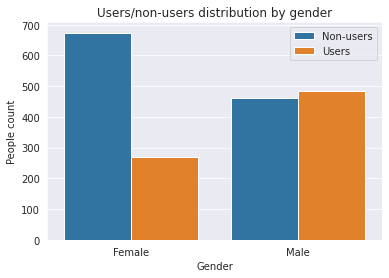

In [57]:
plt.figure()
sns.countplot(data=data_ecstasy, x='Gender', hue='Ecstasy')
plt.title('Users/non-users distribution by gender')
plt.ylabel('People count')
plt.legend(['Non-users', 'Users'])
plt.show()

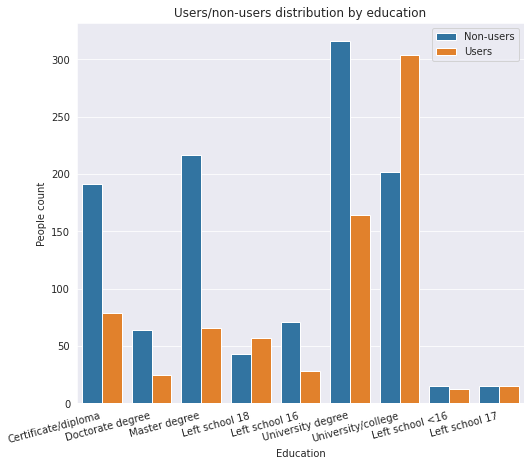

In [58]:
plt.figure(figsize=(8, 7))
chart = sns.countplot(data=data_ecstasy, x='Education', hue='Ecstasy')
chart.set_xticklabels(chart.get_xticklabels(), rotation=15, horizontalalignment='right')
plt.title('Users/non-users distribution by education')
plt.ylabel('People count')
plt.legend(['Non-users', 'Users'])
plt.show()

In [59]:
print('Распределение users/non-users по уровню образования в процентном соотношении в каждой группе.\n')

for val in data_ecstasy['Education'].unique():
  print(val)
  print(np.around(data_ecstasy[data_ecstasy['Education'] == val]['Ecstasy'].value_counts(normalize=True) * 100, 2))
  print()

Распределение users/non-users по уровню образования в процентном соотношении в каждой группе.

Certificate/diploma
0    70.74
1    29.26
Name: Ecstasy, dtype: float64

Doctorate degree
0    71.91
1    28.09
Name: Ecstasy, dtype: float64

Master degree
0    76.68
1    23.32
Name: Ecstasy, dtype: float64

Left school 18
1    57.0
0    43.0
Name: Ecstasy, dtype: float64

Left school 16
0    71.72
1    28.28
Name: Ecstasy, dtype: float64

University degree
0    65.83
1    34.17
Name: Ecstasy, dtype: float64

University/college
1    60.08
0    39.92
Name: Ecstasy, dtype: float64

Left school <16
0    53.57
1    46.43
Name: Ecstasy, dtype: float64

Left school 17
1    50.0
0    50.0
Name: Ecstasy, dtype: float64



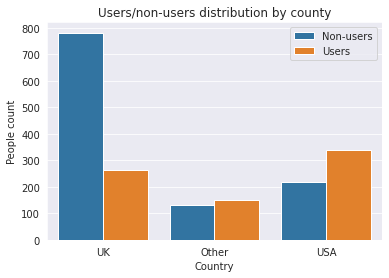

In [60]:
plt.figure()
sns.countplot(data=data_ecstasy, x='Country', hue='Ecstasy')
plt.title('Users/non-users distribution by county')
plt.ylabel('People count')
plt.legend(['Non-users', 'Users'])
plt.show()

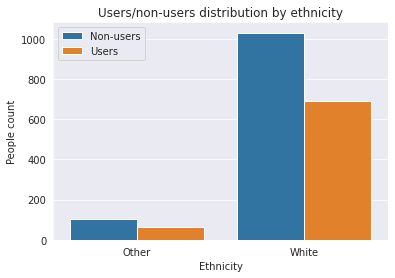

In [61]:
plt.figure()
chart = sns.countplot(data=data_ecstasy, x='Ethnicity', hue='Ecstasy')
plt.title('Users/non-users distribution by ethnicity')
plt.ylabel('People count')
plt.legend(['Non-users', 'Users'])
plt.show()

A first look at the demographic data allows us to say the following:

*   Young people (from 18 to 34 years old) take ecstasy more often than others.
*   Men take ecstasy more often than women.
*   Those who drop out of school before the age of 16 take ecstasy more often than others.
*   In the United States, ecstasy is taken more often than in other countries.
*   White people are more likely to take ecstasy than others.

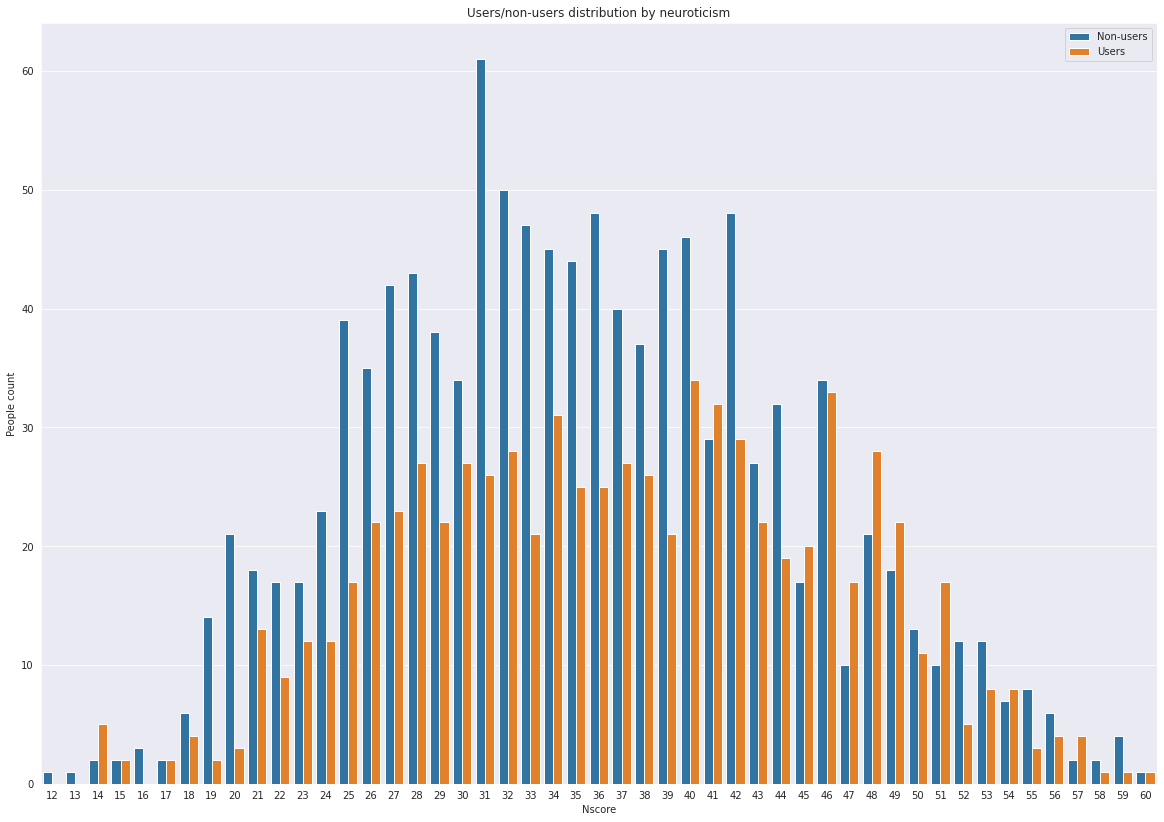

In [62]:
plt.figure(figsize=(20, 14))
sns.countplot(data=data_ecstasy, x='Nscore', hue='Ecstasy')
plt.title('Users/non-users distribution by neuroticism')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

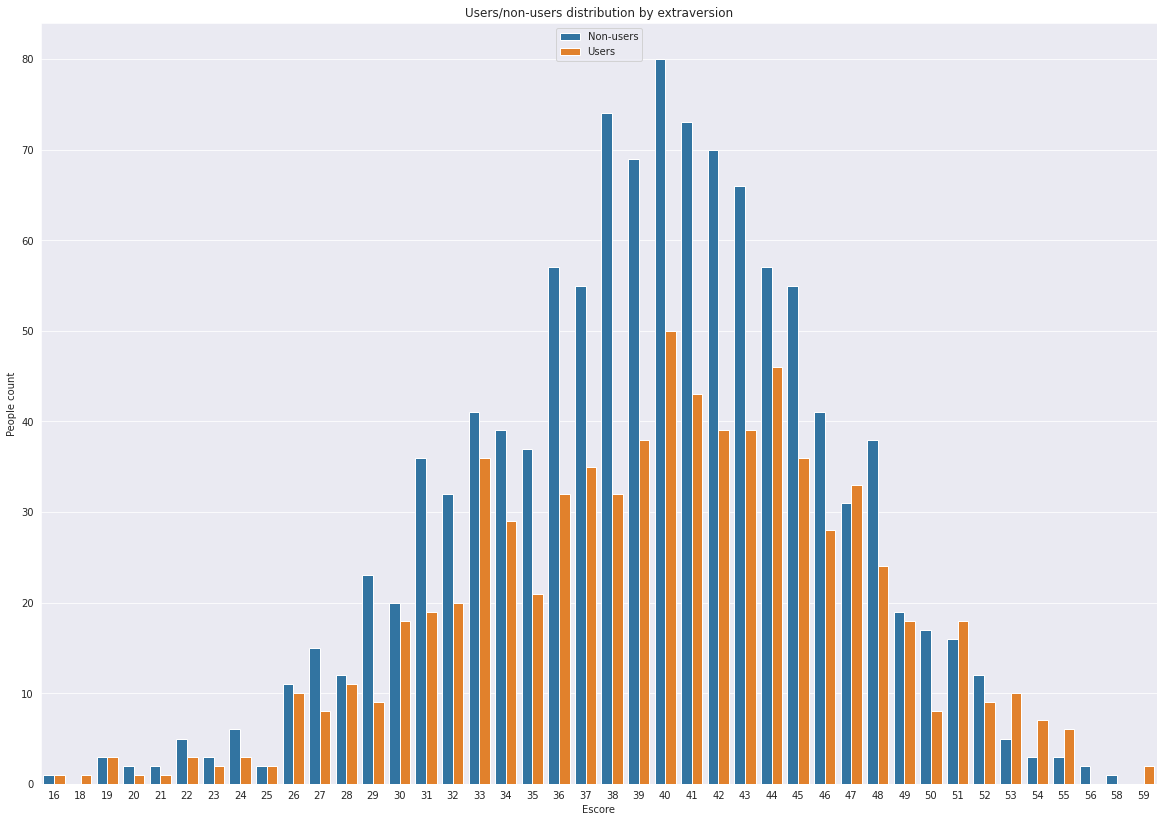

In [63]:
plt.figure(figsize=(20, 14))
sns.countplot(data=data_ecstasy, x='Escore', hue='Ecstasy')
plt.title('Users/non-users distribution by extraversion')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

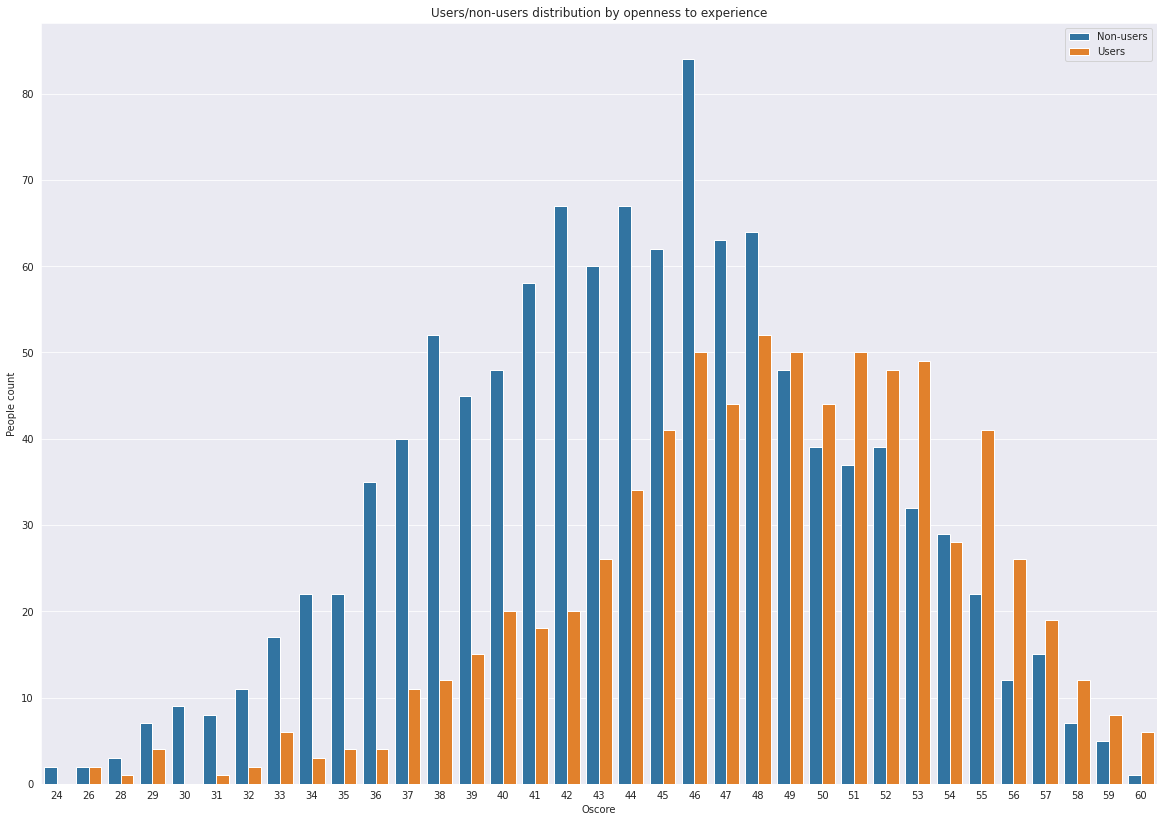

In [64]:
plt.figure(figsize=(20, 14))
sns.countplot(data=data_ecstasy, x='Oscore', hue='Ecstasy')
plt.title('Users/non-users distribution by openness to experience')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

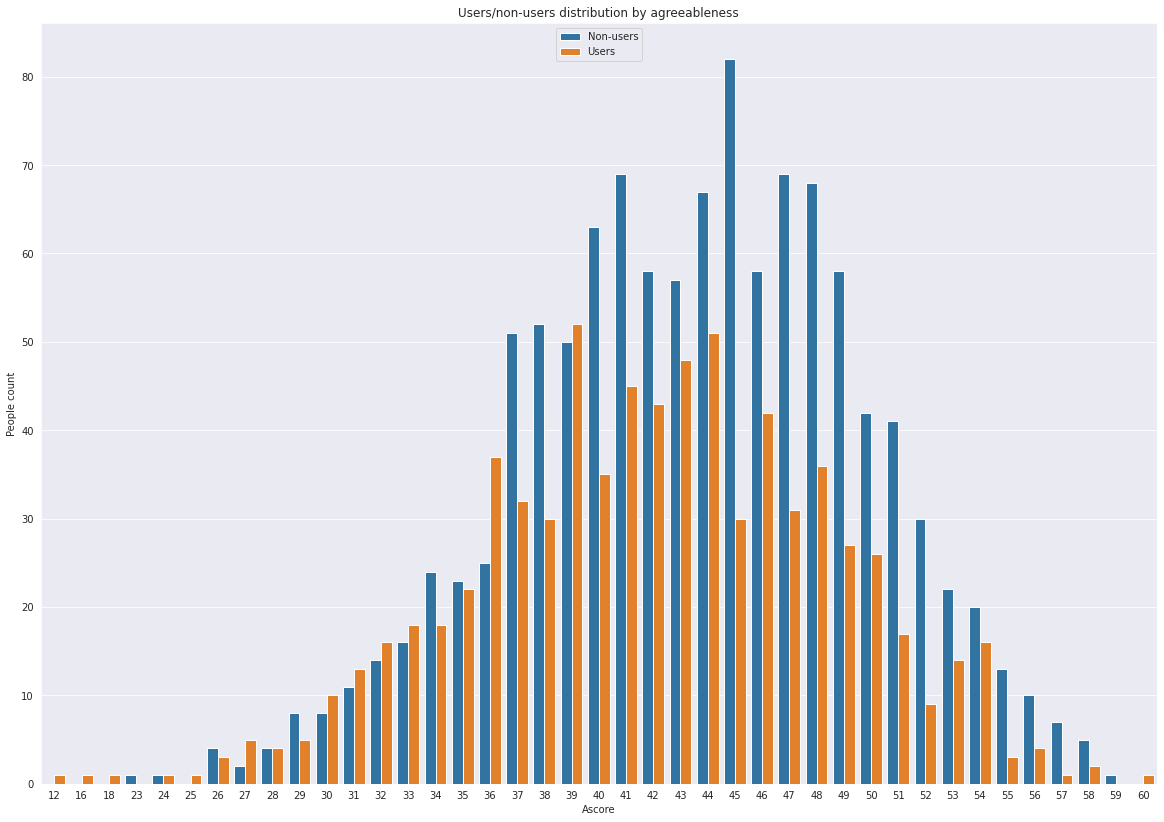

In [65]:
plt.figure(figsize=(20, 14))
sns.countplot(data=data_ecstasy, x='Ascore', hue='Ecstasy')
plt.title('Users/non-users distribution by agreeableness')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

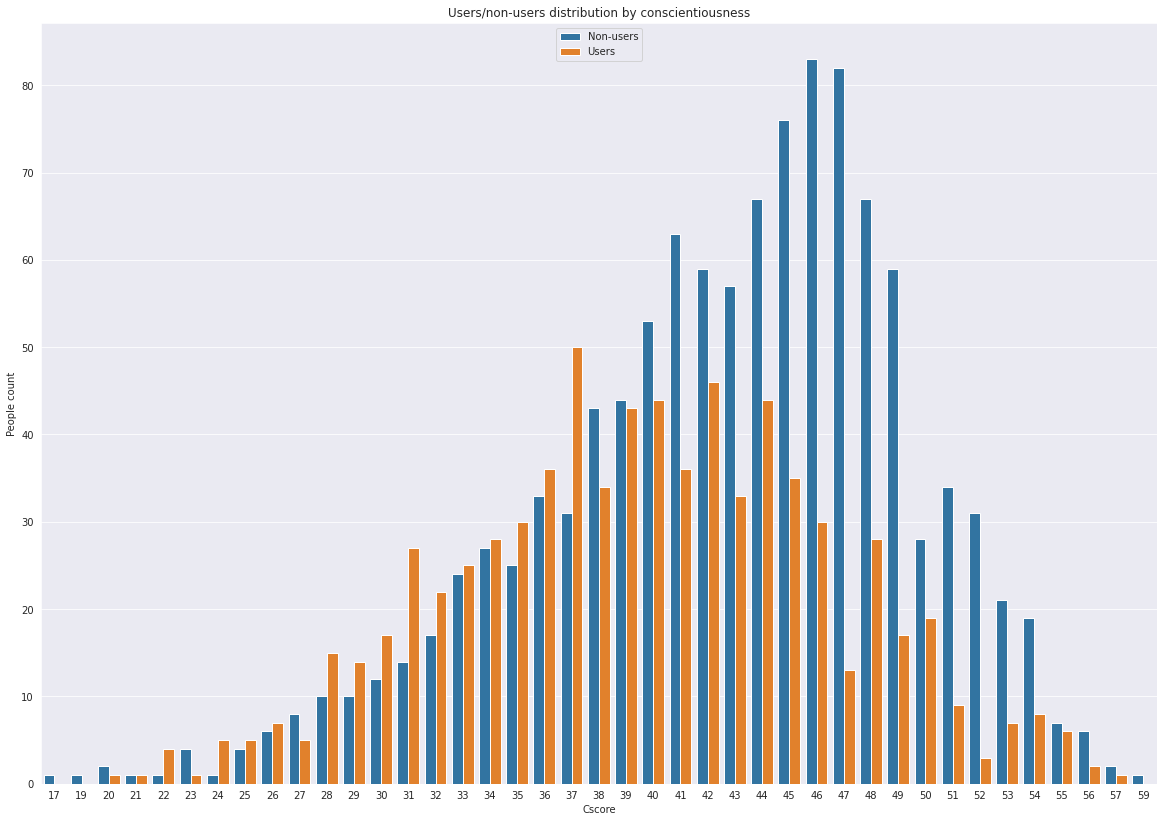

In [66]:
plt.figure(figsize=(20, 14))
sns.countplot(data=data_ecstasy, x='Cscore', hue='Ecstasy')
plt.title('Users/non-users distribution by conscientiousness')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

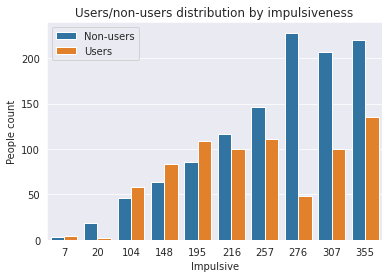

In [67]:
plt.figure()
sns.countplot(data=data_ecstasy, x='Impulsive', hue='Ecstasy')
plt.title('Users/non-users distribution by impulsiveness')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()

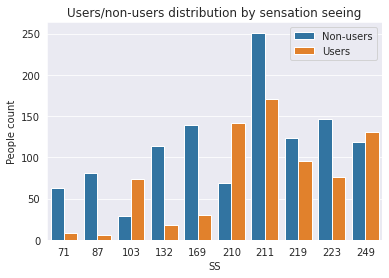

In [68]:
plt.figure()
sns.countplot(data=data_ecstasy, x='SS', hue='Ecstasy')
plt.title('Users/non-users distribution by sensation seeing')
plt.legend(['Non-users', 'Users'])
plt.ylabel('People count')
plt.show()


The analysis of psychological tests allows us to say the following:
*   People with a high nscore value (neuroticism) are more likely to take ecstasy. The lower the nscore, the fewer people take ecstasy.
*   People with a low ascore and сscore (agreeableness and conscientiousness) are more likely to take ecstasy.
*   The lower the impulsivity, the more often people take ecstasy.



## Model training

In [69]:
y = data_ecstasy['Ecstasy']
X = data_ecstasy.drop('Ecstasy', axis=1)
X = one_hot_encoding(X, demografic_features)
X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])

In [70]:
X.head()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Gender_Female,Gender_Male,Education_Certificate/diploma,Education_Doctorate degree,Education_Left school 16,Education_Left school 17,Education_Left school 18,Education_Left school <16,Education_Master degree,Education_University degree,Education_University/college,Country_Other,Country_UK,Country_USA,Ethnicity_Other,Ethnicity_White
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.337059,-0.528234,-0.571966,-0.911428,0.080816,1.303400,-1.192420,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,-0.757818,1.835144,1.404350,0.797602,-0.062764,0.678848,0.614215,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,-0.538842,0.801166,-0.876015,-1.688260,-1.067821,0.275492,1.130396,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,-0.210379,-0.823656,0.036131,0.642236,0.655134,0.275492,-1.192420,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
5,0.775010,-1.709922,-0.419942,-0.289962,1.229453,1.303400,0.614215,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


We will train 4 models for classification: decision tree, random forest, kNN, logistic regression.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [72]:
tree = DecisionTreeClassifier(random_state=17)
rf = RandomForestClassifier(random_state=17)
knn = KNeighborsClassifier()
logreg = LogisticRegression(random_state=17)

models = [tree, rf, knn, logreg]

for model in models:
  model.fit(X_train, y_train)

In [75]:
print('Metrics on test data:\n')
print(f'Decision tree sensitivity: {recall_score(y_test, tree.predict(X_test))}; specificity: {recall_score(y_test, tree.predict(X_test), pos_label=0)}')
print(f'Random forest sensitivity: {recall_score(y_test, rf.predict(X_test))}; specificity: {recall_score(y_test, rf.predict(X_test), pos_label=0)}')
print(f'kNN sensitivity: {recall_score(y_test, knn.predict(X_test))}; specificity: {recall_score(y_test, knn.predict(X_test), pos_label=0)}')
print(f'Logistic regression sensitivity: {recall_score(y_test, logreg.predict(X_test))}; specificity: {recall_score(y_test, logreg.predict(X_test), pos_label=0)}')

Metrics on test data:

Decision tree sensitivity: 0.5560538116591929; specificity: 0.7434402332361516
Random forest sensitivity: 0.6188340807174888; specificity: 0.8192419825072886
kNN sensitivity: 0.6098654708520179; specificity: 0.7755102040816326
Logistic regression sensitivity: 0.6278026905829597; specificity: 0.8250728862973761


In [76]:
print('Metrics on full dataset:\n')
print(f'Decision tree sensitivity: {recall_score(y, tree.predict(X))}; specificity: {recall_score(y, tree.predict(X), pos_label=0)}')
print(f'Random forest sensitivity: {recall_score(y, rf.predict(X))}; specificity: {recall_score(y, rf.predict(X), pos_label=0)}')
print(f'kNN sensitivity: {recall_score(y, knn.predict(X))}; specificity: {recall_score(y, knn.predict(X), pos_label=0)}')
print(f'Logistic regression sensitivity: {recall_score(y, logreg.predict(X))}; specificity: {recall_score(y, logreg.predict(X), pos_label=0)}')

Metrics on full dataset:

Decision tree sensitivity: 0.8681757656458056; specificity: 0.9223985890652557
Random forest sensitivity: 0.8868175765645806; specificity: 0.9453262786596119
kNN sensitivity: 0.7270306258322237; specificity: 0.8051146384479718
Logistic regression sensitivity: 0.6458055925432756; specificity: 0.8139329805996472


## Cross-validation

### Decision tree

In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [79]:
param_grid = {
    'max_depth': list(range(2, 13, 2)),
    'min_samples_split': list(range(2, 9, 2)),
    'min_samples_leaf': list(range(1, 9, 2)),
    'max_features': ['auto', 'sqrt', 'log2']
}

tree_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=17), 
                         param_grid=param_grid,
                         n_jobs=-1,
                         cv=skf)

tree_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [80]:
tree_grid.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [81]:
print('Metrics on test data for decision tree after CV:\n')
print(f'sensitivity: {recall_score(y_test, tree_grid.best_estimator_.predict(X_test))};')
print(f'specificity: {recall_score(y_test, tree_grid.best_estimator_.predict(X_test), pos_label=0)}')

Metrics on test data for decision tree after CV:

sensitivity: 0.672645739910314;
specificity: 0.7521865889212828


In [82]:
print('Metrics on full dataset for decision tree after CV:\n')
print(f'sensitivity: {recall_score(y, tree_grid.best_estimator_.predict(X))};')
print(f'specificity: {recall_score(y, tree_grid.best_estimator_.predict(X), pos_label=0)}')

Metrics on full dataset for decision tree after CV:

sensitivity: 0.715046604527297;
specificity: 0.7469135802469136


### Random forest

In [101]:
param_grid = {
    'n_estimators': list(range(1, 102, 5)),
    'max_depth': list(range(2, 13, 2)),
    'min_samples_split': list(range(2, 9, 2)),
    'min_samples_leaf': list(range(1, 9, 2)),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=17), 
                       param_grid=param_grid,
                       n_jobs=-1,
                       cv=skf)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [102]:
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 81}

In [103]:
print('Metrics on test data for random forest after CV:\n')
print(f'sensitivity: {recall_score(y_test, rf_grid.best_estimator_.predict(X_test))};')
print(f'specificity: {recall_score(y_test, rf_grid.best_estimator_.predict(X_test), pos_label=0)}')

Metrics on test data for random forest after CV:

sensitivity: 0.6188340807174888;
specificity: 0.8309037900874635


In [104]:
print('Metrics on full dataset for random forest after CV:\n')
print(f'sensitivity: {recall_score(y, rf_grid.best_estimator_.predict(X))};')
print(f'specificity: {recall_score(y, rf_grid.best_estimator_.predict(X), pos_label=0)}')

Metrics on full dataset for random forest after CV:

sensitivity: 0.7683089214380826;
specificity: 0.8853615520282186


### kNN

In [107]:
param_grid = {
    'n_neighbors': list(range(1, 50, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=skf)

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [108]:
knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 37, 'weights': 'uniform'}

In [109]:
print('Metrics on test data for kNN after CV:\n')
print(f'sensitivity: {recall_score(y_test, knn_grid.best_estimator_.predict(X_test))};')
print(f'specificity: {recall_score(y_test, knn_grid.best_estimator_.predict(X_test), pos_label=0)}')

Metrics on test data for kNN after CV:

sensitivity: 0.6502242152466368;
specificity: 0.8017492711370262


In [110]:
print('Metrics on full dataset for kNN after CV:\n')
print(f'sensitivity: {recall_score(y, knn_grid.best_estimator_.predict(X))};')
print(f'specificity: {recall_score(y, knn_grid.best_estimator_.predict(X), pos_label=0)}')

Metrics on full dataset for kNN after CV:

sensitivity: 0.6737683089214381;
specificity: 0.7954144620811288


### Logistic regresion

In [111]:
logregcv = LogisticRegressionCV(Cs=np.logspace(-4, 4, num=20), cv=skf, max_iter=10000, random_state=17, n_jobs=-1)
logregcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=10000, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [112]:
logregcv.C_

array([1.62377674])

In [113]:
print('Metrics on test data for logistic regression after CV:\n')
print(f'sensitivity: {recall_score(y_test, logregcv.predict(X_test))};')
print(f'specificity: {recall_score(y_test, logregcv.predict(X_test), pos_label=0)}')

Metrics on test data for logistic regression after CV:

sensitivity: 0.6278026905829597;
specificity: 0.8221574344023324


In [114]:
print('Metrics on full dataset for logistic regression after CV:\n')
print(f'sensitivity: {recall_score(y, logregcv.predict(X))};')
print(f'specificity: {recall_score(y, logregcv.predict(X), pos_label=0)}')

Metrics on full dataset for logistic regression after CV:

sensitivity: 0.6458055925432756;
specificity: 0.8121693121693122
